In [3]:
# Importing important libraries
import numpy as np 
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import resample
# Import StandardScaler from sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Use raw string to avoid unicode escape issues
data = pd.read_csv(r'C:\Users\USER\Desktop\flight_train.csv')

# Display the first few rows of the dataframe
print(data.head())


   MEMBER_NO    FFP_DATE FIRST_FLIGHT_DATE GENDER  FFP_TIER    WORK_CITY  \
0      54993  11-02-2006        12/24/2008   Male         6            .   
1      28065   2/19/2007        08-03-2007   Male         6          NaN   
2      55106  02-01-2007         8/30/2007   Male         6            .   
3      21189   8/22/2008         8/23/2008   Male         5  Los Angeles   
4      39546  04-10-2009         4/15/2009   Male         6      guiyang   

  WORK_PROVINCE WORK_COUNTRY   AGE  LOAD_TIME  ...  SUM_YR_2  SEG_KM_SUM  \
0       beijing           CN  31.0  3/31/2014  ...  234188.0      580717   
1       beijing           CN  42.0  3/31/2014  ...  167434.0      293678   
2       beijing           CN  40.0  3/31/2014  ...  164982.0      283712   
3            CA           US  64.0  3/31/2014  ...  125500.0      281336   
4       guizhou           CN  48.0  3/31/2014  ...  130702.0      309928   

   LAST_FLIGHT_DATE  LAST_TO_END  AVG_INTERVAL MAX_INTERVAL  EXCHANGE_COUNT  \
0      

In [5]:
duplicate_rows = data.duplicated().sum()
print(f'Duplicate rows: {duplicate_rows}')

# Drop duplicates
data = data.drop_duplicates()

# Verify dataset shape
print(f'Data shape after removing duplicates: {data.shape}')

Duplicate rows: 0
Data shape after removing duplicates: (55000, 23)


In [6]:
print(data.info())
print(data.describe())
print(data.head())
# Check for missing values
data.isnull().sum()
# Get unique values for categorical columns
data['FLIGHT_COUNT'].unique()

# Get value counts for categorical columns
data['FLIGHT_COUNT'].value_counts()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55000 entries, 0 to 54999
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MEMBER_NO          55000 non-null  int64  
 1   FFP_DATE           55000 non-null  object 
 2   FIRST_FLIGHT_DATE  55000 non-null  object 
 3   GENDER             54997 non-null  object 
 4   FFP_TIER           55000 non-null  int64  
 5   WORK_CITY          53034 non-null  object 
 6   WORK_PROVINCE      52216 non-null  object 
 7   WORK_COUNTRY       54980 non-null  object 
 8   AGE                54658 non-null  float64
 9   LOAD_TIME          55000 non-null  object 
 10  FLIGHT_COUNT       55000 non-null  int64  
 11  BP_SUM             55000 non-null  int64  
 12  SUM_YR_1           54738 non-null  float64
 13  SUM_YR_2           54937 non-null  float64
 14  SEG_KM_SUM         55000 non-null  int64  
 15  LAST_FLIGHT_DATE   55000 non-null  object 
 16  LAST_TO_END        550

FLIGHT_COUNT
4      5061
3      4920
2      4561
5      4219
6      3633
       ... 
154       1
189       1
117       1
137       1
210       1
Name: count, Length: 153, dtype: int64

In [7]:
# Separate numerical and non-numerical columns
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns
non_numerical_columns = data.select_dtypes(exclude=['float64', 'int64']).columns

# Fill missing values in numerical columns with median
data[numerical_columns] = data[numerical_columns].fillna(data[numerical_columns].median())

# For non-numerical columns, handle missing values as needed
# Example: Filling missing dates with the most frequent value (mode)
for col in non_numerical_columns:
    data[col] = data[col].fillna(data[col].mode()[0])

# Now, the data should have no missing values, and you can proceed with further preprocessing

In [8]:
# Convert 'LOAD_TIME' and 'FIRST_FLIGHT_DATE' to datetime, with error handling
data['LOAD_TIME'] = pd.to_datetime(data['LOAD_TIME'], dayfirst=True, errors='coerce')
data['FIRST_FLIGHT_DATE'] = pd.to_datetime(data['FIRST_FLIGHT_DATE'], dayfirst=True, errors='coerce')

# Check for any rows where the conversion failed
invalid_dates = data[data['FIRST_FLIGHT_DATE'].isna()]

# Optionally, print or handle invalid date rows
print("Rows with invalid dates:", invalid_dates)

# Drop rows with missing or invalid dates in 'FIRST_FLIGHT_DATE' if necessary
data.dropna(subset=['FIRST_FLIGHT_DATE'], inplace=True)

# Create a new feature for booking lead time
data['booking_lead_time'] = (data['LOAD_TIME'] - data['FIRST_FLIGHT_DATE']).dt.days

# Create a feature to represent frequent travelers
data['frequent_traveler'] = data['FLIGHT_COUNT'].apply(lambda x: 1 if x > 5 else 0)

print(data[['LOAD_TIME', 'FIRST_FLIGHT_DATE', 'booking_lead_time', 'frequent_traveler']].head())

Rows with invalid dates:        MEMBER_NO    FFP_DATE FIRST_FLIGHT_DATE  GENDER  FFP_TIER   WORK_CITY  \
1          28065   2/19/2007               NaT    Male         6   guangzhou   
7          22631  04-09-2010               NaT  Female         6  wenzhoushi   
8          32197  06-07-2011               NaT    Male         5      DRANCY   
9          31645  07-05-2010               NaT  Female         6     wenzhou   
11         37994  11/13/2004               NaT    Male         6     beijing   
...          ...         ...               ...     ...       ...         ...   
54991      49333  11-07-2009               NaT    Male         4    liaoyuan   
54992      52356  01-09-2013               NaT  Female         4     beijing   
54993      60426  04-08-2012               NaT  Female         4   guangzhou   
54996       3826  11/14/2008               NaT    Male         4   guangzhou   
54999      21795  12/18/2008               NaT    Male         4   zhongqing   

      WORK_PRO

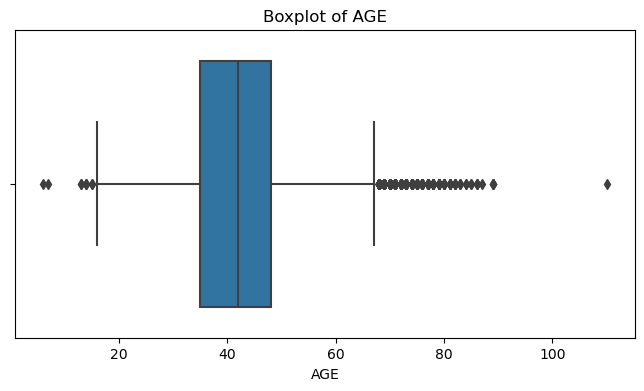

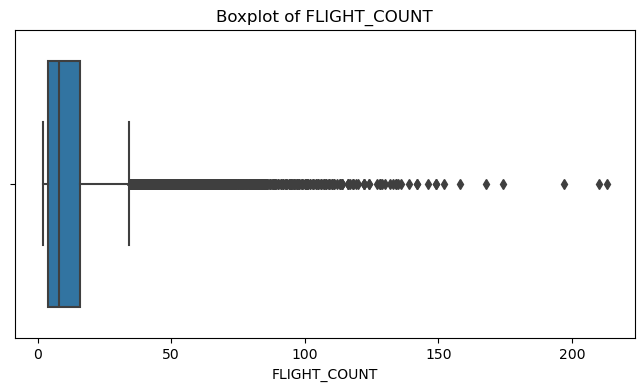

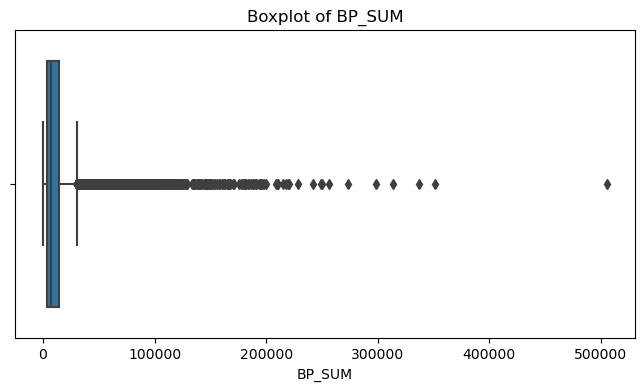

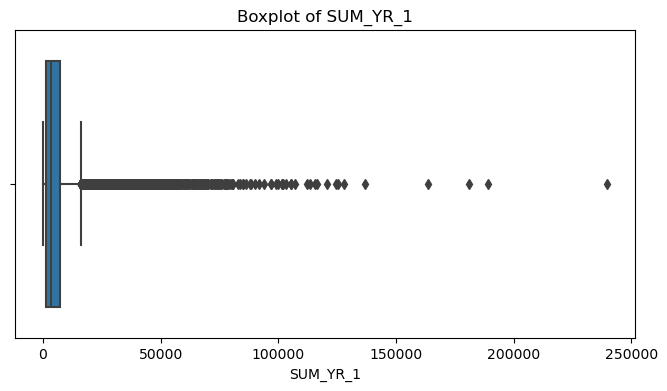

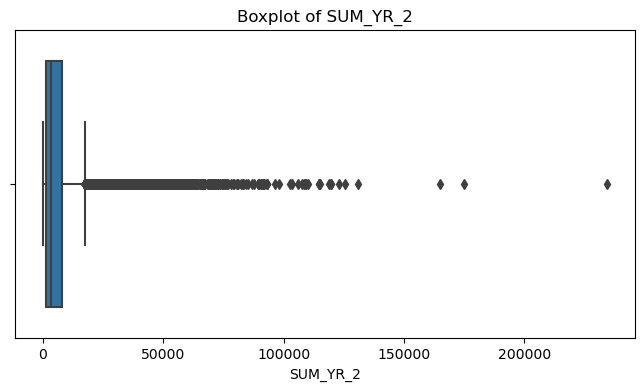

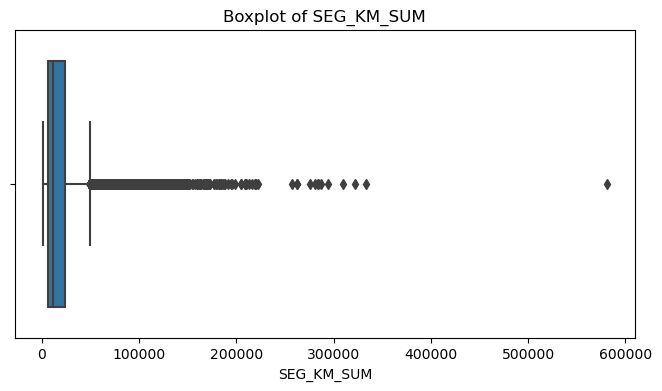

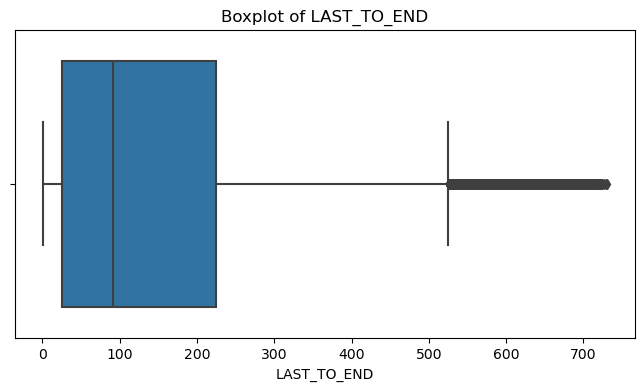

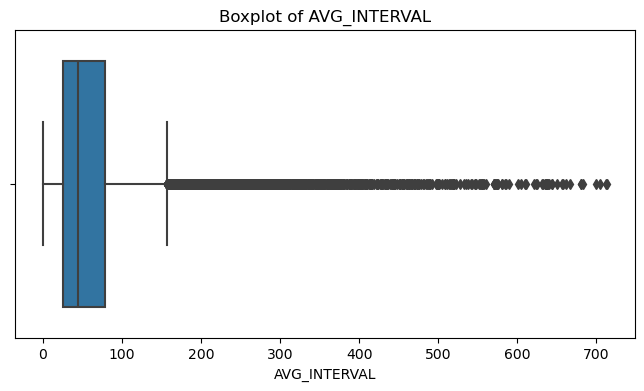

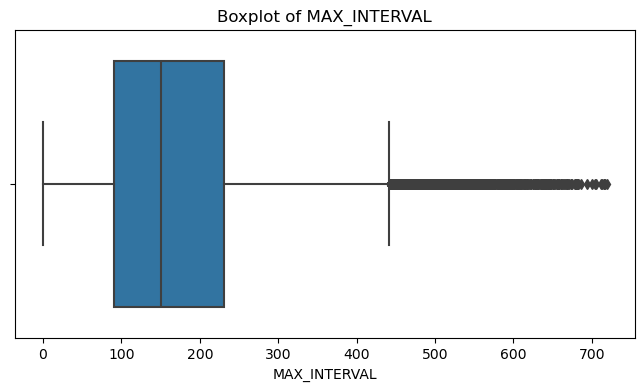

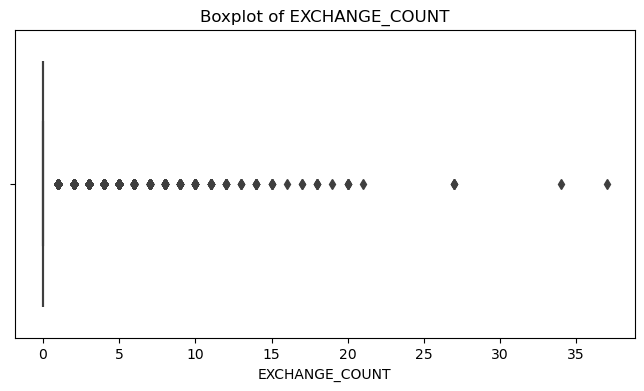

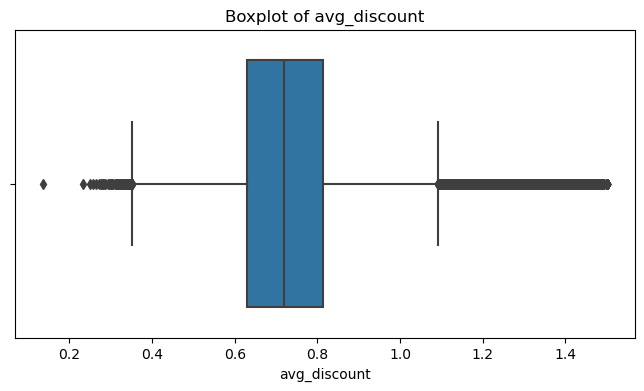

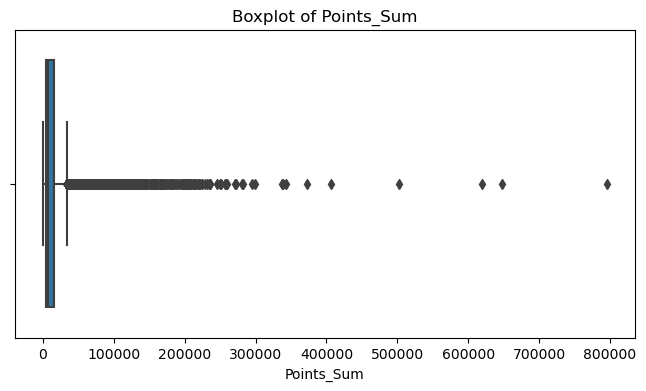

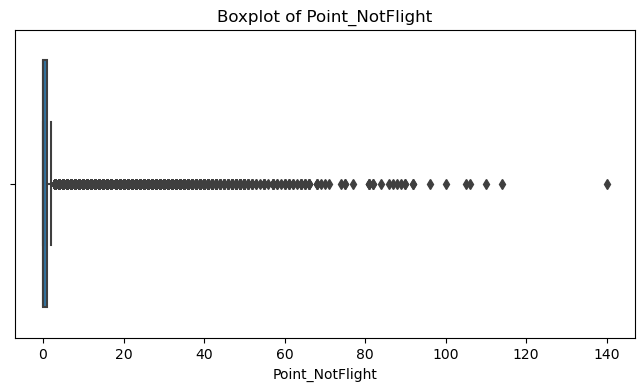

In [9]:
# List of numerical columns from your dataset
numerical_columns = ['AGE', 'FLIGHT_COUNT', 'BP_SUM', 'SUM_YR_1', 'SUM_YR_2', 'SEG_KM_SUM', 
                     'LAST_TO_END', 'AVG_INTERVAL', 'MAX_INTERVAL', 'EXCHANGE_COUNT', 
                     'avg_discount', 'Points_Sum', 'Point_NotFlight']

# Plot boxplots for all numerical columns
for column in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

In [10]:
#Handle Categorical Features
# Separate categorical columns
categorical_features = data.select_dtypes(include=['object'])

# Impute missing values in categorical features with mode (most frequent value)
for column in categorical_features.columns:
    mode_value = categorical_features[column].mode()[0]
    categorical_features[column].fillna(mode_value, inplace=True)

print(categorical_features.isnull().sum())



FFP_DATE            0
GENDER              0
WORK_CITY           0
WORK_PROVINCE       0
WORK_COUNTRY        0
LAST_FLIGHT_DATE    0
dtype: int64


In [13]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' to avoid multicollinearity
data_encoded = encoder.fit_transform(categorical_features)
data_encoded_df = pd.DataFrame(data_encoded, columns=encoder.get_feature_names_out(categorical_features.columns))

# Example of combining with scaled numerical features
data_final = pd.concat([data_scaled_df, data_encoded_df], axis=1)


In [12]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd

# Assume 'data' is your original DataFrame
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()  # Example: object dtype for categorical
numerical_columns = data.select_dtypes(include=['number']).columns.tolist()  # Example: number dtype for numerical

# Step 1: Scale numerical columns
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[numerical_columns])
data_scaled_df = pd.DataFrame(data_scaled, columns=numerical_columns)

# Step 2: One-hot encode categorical columns
encoder = OneHotEncoder(sparse=False, drop='first')  # drop='first' to avoid multicollinearity
data_encoded = encoder.fit_transform(data[categorical_columns])
data_encoded_df = pd.DataFrame(data_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# Step 3: Concatenate the scaled numerical features and the encoded categorical features
data_final = pd.concat([data_scaled_df, data_encoded_df], axis=1)

# Verify the final DataFrame
print(data_final.head())

   MEMBER_NO  FFP_TIER       AGE  FLIGHT_COUNT     BP_SUM   SUM_YR_1  \
0   1.291006  4.750742 -1.200432     13.617908  29.155464  27.435704   
1   1.297222  4.750742 -0.275344      8.429797  20.040487  18.516777   
2  -0.568294  2.229985  2.191557      0.682218  19.221819  12.965437   
3   0.441385  4.750742  0.546956      9.605769  15.468778  13.929652   
4   1.399856  4.750742  2.191557      5.455280  17.804095  12.497306   

    SUM_YR_2  SEG_KM_SUM  LAST_TO_END  AVG_INTERVAL  ...  \
0  25.215109   26.285949    -0.909083     -0.924258  ...   
1  17.558638   12.385267    -0.850147     -0.896119  ...   
2  13.190623   12.274063    -0.343294     -0.546332  ...   
3  13.766137   13.612250    -0.885509     -0.904031  ...   
4   7.818946   12.894154    -0.449380     -0.869062  ...   

   LAST_FLIGHT_DATE_9/26/2012  LAST_FLIGHT_DATE_9/26/2013  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                      

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to find the optimal value of k
wcss = []

# Sample a subset of the data if it's large
sample_data = data_final.sample(frac=0.1, random_state=42)  # 10% sample

for i in range(1, 11):  # Trying different numbers of clusters from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=5, random_state=42)
    kmeans.fit(sample_data)
    wcss.append(kmeans.inertia_)  # Append WCSS (Inertia)

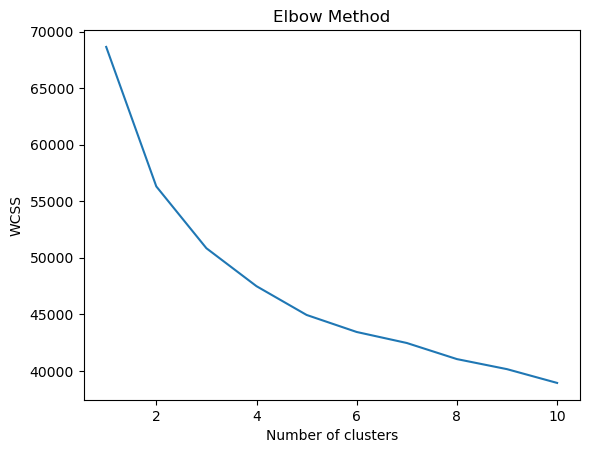

In [16]:
# Plot the Elbow Graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [19]:
from sklearn.cluster import KMeans

# Assuming the data has been preprocessed (data_final)
optimal_k = 4  # Set your optimal number of clusters

# Reduce iterations and data size if necessary
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=100, n_init=10, random_state=42)

# Fit and predict the clusters (try on a smaller dataset or with PCA applied)
data['Cluster'] = kmeans.fit_predict(data_final)

print(data['Cluster'].head())  # Print the cluster assignments for initial rows

0    2
2    2
3    2
4    2
5    2
Name: Cluster, dtype: int32


In [23]:


# Train KMeans model
optimal_k = 4  # Set the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
data['Cluster'] = kmeans.fit_predict(data_scaled)

# Finding the centroids
centroids = kmeans.cluster_centers_
print('Cluster Centroids:\n', centroids)

# Print the first few cluster assignments
print(data['Cluster'].head())

Cluster Centroids:
 [[-0.01209409 -0.2429681  -0.06982943 -0.63401045 -0.48875472 -0.48861041
  -0.46644252 -0.57133585 -0.18074984  1.75287489  1.46558693 -0.24960212
  -0.07243193 -0.44032974 -0.14575725 -0.10161188 -1.17563181]
 [ 0.00863147 -0.12175245  0.02953091  0.11713254  0.0080024   0.00368981
   0.04281024  0.07801789 -0.38876023 -0.24257745  0.02899466 -0.04219002
  -0.08359352 -0.01124779 -0.0068338   0.07355343  0.71867254]
 [-0.03001081  2.27505509  0.21119778  2.58195106  2.60719845  2.31454639
   2.50025175  2.54910463 -0.75098203 -0.72224086 -0.72038001  1.75364188
   0.69649167  2.51629632  1.01578229  0.62304631  0.71970664]
 [-0.0032651  -0.24496218 -0.08701555 -0.63997335 -0.48779194 -0.39031046
  -0.55042973 -0.57964275  1.23838029 -0.33915704 -0.78445807 -0.26853492
   0.03081793 -0.44692023 -0.19548396 -0.29181251 -1.12793746]]
0    2
2    2
3    2
4    2
5    2
Name: Cluster, dtype: int32


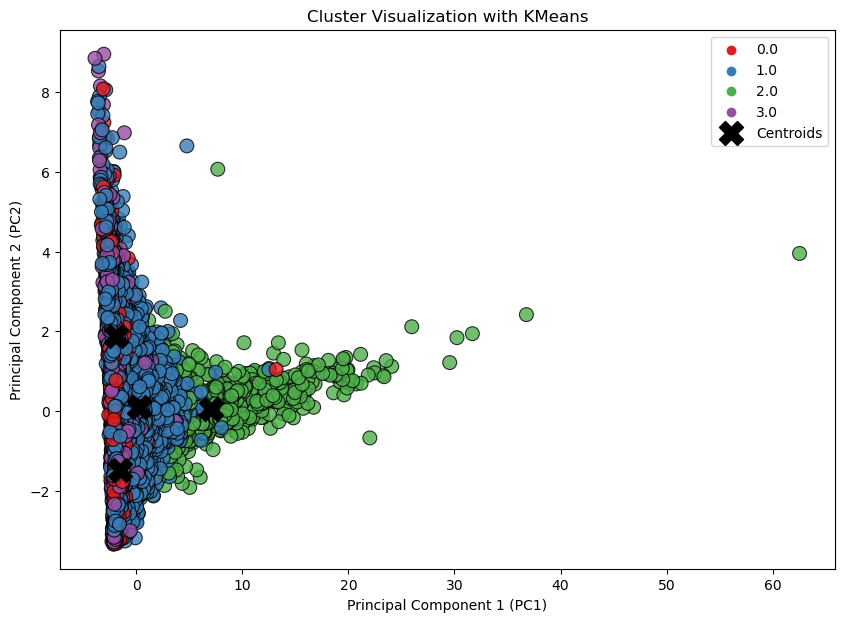

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Reduce dimensions to 2D using PCA for visualization purposes
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

# Create a DataFrame to hold the reduced PCA components and the cluster labels
data_pca_df = pd.DataFrame(data_pca, columns=['PC1', 'PC2'])
data_pca_df['Cluster'] = data['Cluster']

# Plot the clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', palette='Set1', data=data_pca_df, s=100, alpha=0.8, edgecolor='k')

# Mark the centroids on the graph
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=300, c='black', marker='X', label='Centroids')

plt.title('Cluster Visualization with KMeans')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.legend()
plt.show()